In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/datasets/eteplygina/combined_data.csv')

# Drop unnecessary columns
data = data.drop(['time_rounded', 'shock_time', 'ethnicity', 'gender', 'height', 'weight', 'relative_time', 'age'], axis=1)

# Create label dictionary
label_dict = data.groupby('id')['label'].first().to_dict()

# Split data into train and test sets while preserving IDs
train_ids, test_ids = train_test_split(data['id'].unique(), test_size=0.2, random_state=42)

# Normalize the data for train and test sets separately
scaler = StandardScaler()

# Filter the DataFrame to extract the rows corresponding to train_ids and test_ids
train_data_filtered = data[data['id'].isin(train_ids)].drop(['label'], axis=1)
test_data_filtered = data[data['id'].isin(test_ids)].drop(['label'], axis=1)

# Normalize features
train_data_filtered.iloc[:, 1:] = scaler.fit_transform(train_data_filtered.iloc[:, 1:]).astype('float64')
test_data_filtered.iloc[:, 1:] = scaler.transform(test_data_filtered.iloc[:, 1:]).astype('float64')

# Add labels back to train and test sets for adjustment
train_data_filtered['label'] = data[data['id'].isin(train_ids)]['label'].values
test_data_filtered['label'] = data[data['id'].isin(test_ids)]['label'].values

# Function to relabel positive patients
def relabel_positive_patients(data, label_dict, window_size):
    for id in data['id'].unique():
        if label_dict[id] == 1:
            id_data = data[data['id'] == id]
            end_index = len(id_data)
            start_index = max(0, end_index - window_size * 3)  # 3 windows back for 8 hours (each window overlaps by 50%)
            data.loc[data['id'] == id, 'label'] = 0
            data.loc[id_data.iloc[start_index:end_index].index, 'label'] = 1
    return data

# Relabel positive patients for train and test data
train_data_relabelled = relabel_positive_patients(train_data_filtered, label_dict, window_size=8)
test_data_relabelled = relabel_positive_patients(test_data_filtered, label_dict, window_size=8)

# Function to create sliding windows and engineer features
def create_sliding_windows_with_features(data, ids, window_size, overlap):
    windows_features = []
    window_labels = []
    
    vital_signs = ['heartrate', 'sbp', 'dbp', 'mbp', 'respiration', 'temperature', 'spo2']
    
    for id in ids:
        id_data = data[data['id'] == id]
        id_features = id_data.drop(['id', 'label'], axis=1).values
        id_labels = id_data['label'].values
        
        for start in range(0, len(id_data) - window_size + 1, overlap):
            window_data = id_features[start:start + window_size]
            window_label = id_labels[start:start + window_size].max()  # Max aggregation for window labels
            
            features = {}
            for i, vital_sign in enumerate(vital_signs):
                vital_sign_data = window_data[:, i]
                features[f'mean_{vital_sign}'] = np.mean(vital_sign_data)
                features[f'median_{vital_sign}'] = np.median(vital_sign_data)
                features[f'max_{vital_sign}'] = np.max(vital_sign_data)
                features[f'min_{vital_sign}'] = np.min(vital_sign_data)
                features[f'std_{vital_sign}'] = np.std(vital_sign_data)
                
            windows_features.append(features)
            window_labels.append(window_label)
    
    return pd.DataFrame(windows_features), np.array(window_labels)

# Create sliding windows with features for train and test sets
train_windows_features, train_window_labels = create_sliding_windows_with_features(train_data_relabelled, train_ids, window_size=8, overlap=4)
test_windows_features, test_window_labels = create_sliding_windows_with_features(test_data_relabelled, test_ids, window_size=8, overlap=4)

print("Train windows features shape:", train_windows_features.shape)
print("Test windows features shape:", test_windows_features.shape)
print("Train window labels shape:", train_window_labels.shape)
print("Test window labels shape:", test_window_labels.shape)


Train windows features shape: (232197, 35)
Test windows features shape: (59733, 35)
Train window labels shape: (232197,)
Test window labels shape: (59733,)


In [2]:
print(train_data_relabelled[500:1000])
print(train_windows_features[:15])
print(train_window_labels[:10])

            id  heartrate       sbp       dbp       mbp  respiration  \
659   30009505  -0.689923 -0.059857  1.413629  0.899059     0.762120   
660   30009505  -0.521964 -0.555647  0.534479  0.271940    -0.598043   
661   30009505  -0.521964 -0.555647  0.534479  0.271940    -0.598043   
662   30009505  -0.242033 -0.014786  0.848462  0.773635    -0.792351   
663   30009505  -0.242033 -0.014786  0.848462  0.773635    -0.792351   
...        ...        ...       ...       ...       ...          ...   
1154  38159053   1.381571 -0.510575  0.722869  0.271940     0.373502   
1155  38159053   1.381571 -0.510575  0.722869  0.271940     0.373502   
1156  38159053   1.717489 -0.285216  0.660072  0.209228     0.762120   
1157  38159053   1.717489 -0.285216  0.660072  0.209228     0.762120   
1158  38159053   1.493543 -0.645791  0.534479  0.083805     1.150737   

      temperature      spo2  label  
659      0.282237  0.476982      0  
660      0.602465  0.790189      0  
661      0.602465  0.790

Confusion Matrix:
[[38425 17986]
 [ 1115  2207]]


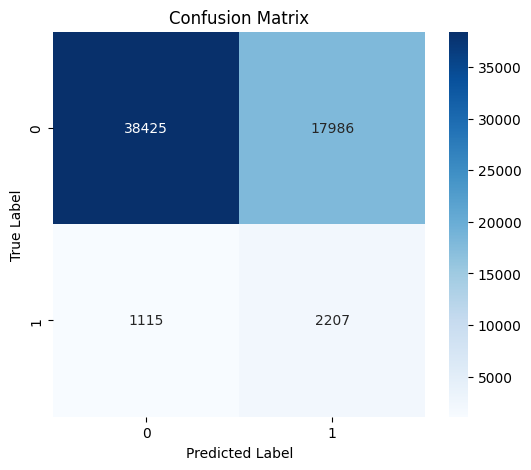

Accuracy: 0.6802270101953694
Precision: 0.10929530035160699
Recall: 0.6643588199879591
F1-score: 0.18770997235806933


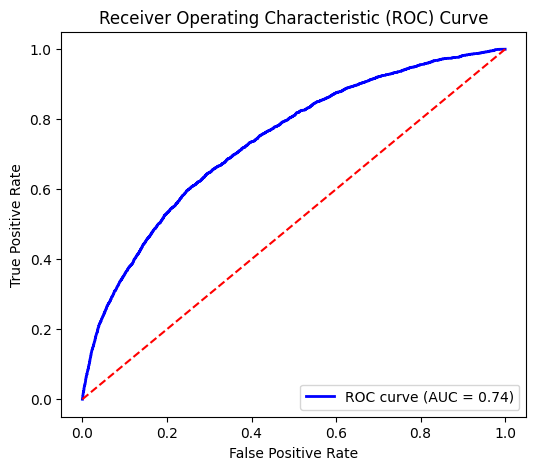

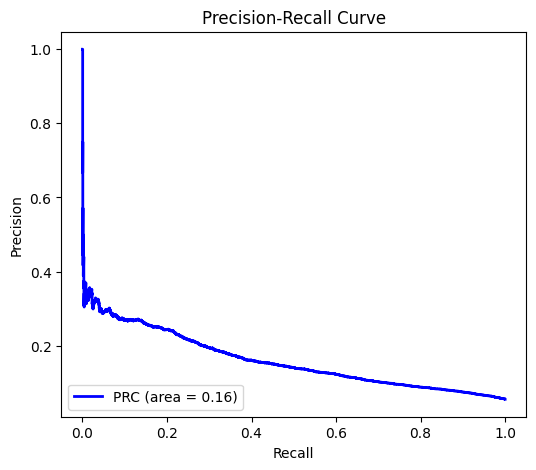

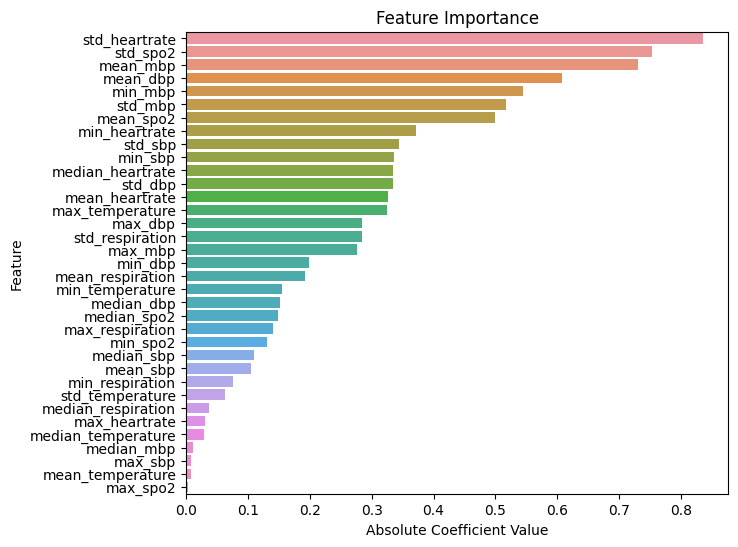

In [8]:

# Train Logistic Regression model
best_hyperparams = {'C': 0.340735565015036, 'solver': 'saga'}
lr = LogisticRegression(
    solver=best_hyperparams['solver'],
    max_iter=16000,
    penalty='l2',
    class_weight='balanced'
)
lr.fit(train_windows_features, train_window_labels)

# Make predictions
y_pred = lr.predict(test_windows_features)

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(test_window_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(test_window_labels, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(test_window_labels, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(test_window_labels, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(test_window_labels, y_pred)
print("F1-score:", f1)

# Calculate probabilities for class 1 (positive class)
y_prob = lr.predict_proba(test_windows_features)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_window_labels, y_prob)

# Calculate AUC score
auc_ = roc_auc_score(test_window_labels, y_prob)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_window_labels, y_prob)

# Calculate Precision-Recall AUC
prc_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PRC (area = {prc_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Retrieve feature names
feature_names = train_windows_features.columns

# Retrieve coefficients
coefficients = lr.coef_[0]

# Create a DataFrame to store feature names and their corresponding coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values to identify the most influential features
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
sorted_coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(7, 6))
sns.barplot(x='Absolute_Coefficient', y='Feature', data=sorted_coefficients_df)
plt.title('Feature Importance')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()
